In [1]:
# import...
import xarray as xr
import os
import pandas as pd
import numpy as np
import metpy.calc as mpcalc
from metpy.units import units
import matplotlib.pyplot as plt
from geopy import distance
import warnings

os.chdir("/Users/etmu9498/research/code/scripts")
import helper_fns
import make_plots
import make_plots_new_heights
import tc_metadata
import cloud_height

In [8]:
# function to make a nice plot of cloud top heights for the given dataset

def pdf_one_tc_eye( new_crl_path, new_crl_name, eyewall_dists):

    # load data
    os.chdir( new_crl_path)
    crl_data = xr.open_dataset( new_crl_name)
    xaxis_data = crl_data.in_situ_distance.values

    # find the indices and values in the crl distance dataset closest to the eyewall_dists limits
    i1, x1 = helper_fns.closest_val( xaxis_data, eyewall_dists[ 0])
    i2, x2 = helper_fns.closest_val( xaxis_data, eyewall_dists[ 1])

    # find cloud top heights for values within the specified eye distance range
    H, xaxis_value = cloud_height.find_cloud_heights(new_crl_name, -30, i1, i2, xaxis ='in-situ-dist', crl_path=new_crl_path, new_heights=True)

    # plot the crl backscattered power figure for helpful testing
    # plt.figure( figsize=(18, 5))
    fig = plt.figure( figsize=(18, 6), facecolor='w')
    helper_fns.change_font_sizes(small=14, medium=16 )

    make_plots_new_heights.plot_power_ch1( new_crl_path, new_crl_name, 'in-situ-dist')
    plt.scatter( xaxis_value, H, c= 'r', s=11, marker='s')
    plt.plot( xaxis_value, H, c=  'r', linewidth=2, label= 'Cloud Top Height')

    plt.xlabel( 'Distance from TC Center ( Km)')
    plt.xlim( eyewall_dists)
    plt.ylim( [ 0, 3.8])


In [3]:
# function to just return the cloud top heights for the chosen data
def height_return( new_crl_path, new_crl_name, eyewall_dists):

    # load data
    os.chdir( new_crl_path)
    crl_data = xr.open_dataset( new_crl_name)
    xaxis_data = crl_data.in_situ_distance.values

    # find the indices and values in the crl distance dataset closest to the eyewall_dists limits
    i1, x1 = helper_fns.closest_val( xaxis_data, eyewall_dists[ 0])
    i2, x2 = helper_fns.closest_val( xaxis_data, eyewall_dists[ 1])

    # find cloud top heights for values within the specified eye distance range
    H, xaxis_value = cloud_height.find_cloud_heights(new_crl_name, -30, i1, i2, xaxis ='in-situ-dist', crl_path=new_crl_path, new_heights=True)

    return H, xaxis_value

In [10]:
# load a test dataset
tcname = 'sam'
dataset = 3
metadata = tc_metadata.all_data(tc=tcname)
path = metadata['um_crl_path']
tdr_name, crl_name = tc_metadata.choose_new_data( tcname, dataset)
eyewall_dists = metadata[ 'in_situ_eyewall_dists'][ dataset] # other option: [ 'eyewall_dists_no_eyewalls']

In [1]:
# cloud cluster test #1
H, xaxis = height_return( path, crl_name, eyewall_dists)


# save total cloud clusters, and the current cluster, in individual lists
H_clusters = []
xaxis_clusters = []

H_cluster_current = []
xaxis_cluster_current = []


# cycle through every cloud height value looking for cloud clusters
for i in range( len( H) - 1):
    
    # same cluster: heights between individual CRL scans are within 250m of each other 
    if abs( H[ i] - H[ i+1]) <= .25: 
        
        # append values to the current cluster list
        H_cluster_current.append( H[ i])
        xaxis_cluster_current.append( float( xaxis[ i].values))
        
    # else case: start of a new cluster
    else:
        
        # append current cloud height to this cluster: it's the last valid value!
        H_cluster_current.append( H[ i])
        xaxis_cluster_current.append( float( xaxis[ i].values))
        
        # append current cloud clusters to total list
        H_clusters.append(  H_cluster_current)
        xaxis_clusters.append(  xaxis_cluster_current)

        # clear current cluster lists
        H_cluster_current = []
        xaxis_cluster_current = []


    # check if there are any last clusters to append at the end of the for loop!
    if i == len( H) - 2:
        # make sure the current cluster has values!
        if len( H_cluster_current) > 0:
            H_clusters.append(  H_cluster_current)
            xaxis_clusters.append(  xaxis_cluster_current)
            

###### testing ############

'''
# why are the last few values not being included in the cloud clusters?
print( np.nanmax( xaxis))
# print( xaxis[-1])
print( H[-1])
print( len( H))
print( len( xaxis))

# sum up the number of height values per cluster and print it
sum = 0
for i in range( len( H_clusters)):
    sum += len( H_clusters[ i])
print( sum)

print( xaxis)
print( xaxis_clusters)
'''

NameError: name 'height_return' is not defined

In [12]:
# find mean height values for each cloud cluster: save them in the same length format as the clusters for plotting!

# initialize a mean height array 
# the array is initialized with empty values and filled in over time
mean_heights = [ None] * len( H_clusters)

# do this for every cloud cluster
for i in range( len( H_clusters)):
    
    # find the mean value
    cluster_mean = np.mean( H_clusters[ i])
    
    # append the mean value to the list created above
    # make sure the number of mean heights matches the number of xaxis values for plotting!
    mean_heights[ i] = [ cluster_mean] * len( H_clusters[ i] )

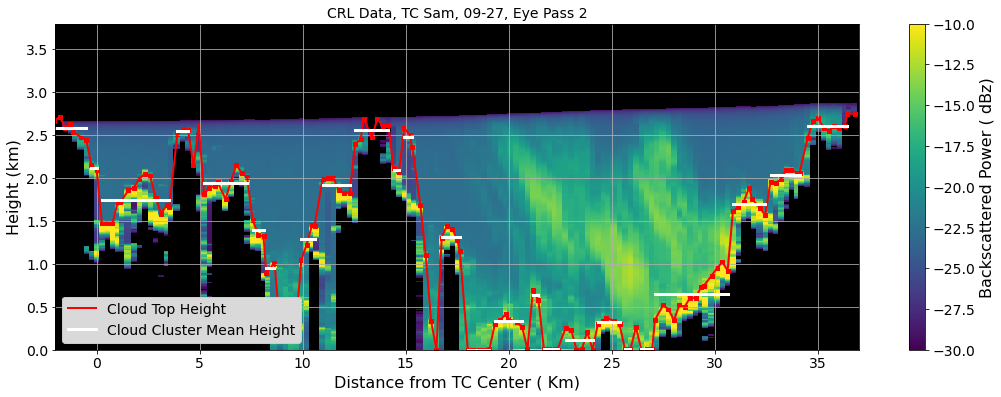

In [13]:
# make a crl plot of cloud top heights for that test dataset, and add horizontal lines for each cloud cluster!

title = ( "CRL Data, TC " + metadata['tc_name'] + ", "
                    + metadata['dates'][ dataset] + ", Eye Pass " + metadata['eye_pass'][ dataset] )
pdf_one_tc_eye( path, crl_name, eyewall_dists)
plt.title( title)


# add mean cloud cluster height lines
for i in range( len( H_clusters)):    
    plt.plot( xaxis_clusters[ i], mean_heights[ i], c='w', linewidth=3)

# make an empty line to add cloud cluster label to legend
plt.plot( -2, -2, c='w', linewidth=3, label='Cloud Cluster Mean Height')
plt.legend(loc='lower left', framealpha=1, facecolor='.85')
